In [1]:
!pip install pycryptodome

In [2]:
from Crypto.Cipher import AES
from Crypto.Util.Padding import pad
from Crypto.Random import get_random_bytes
from Crypto.Cipher import PKCS1_OAEP
from Crypto.PublicKey import RSA

from scipy.io import wavfile
import numpy as np
import matplotlib.pyplot as plt
import random
import string
import IPython.display as ipd
import librosa
import librosa.display

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: WavFileWarning: Chunk (non-data) not understood, skipping it.
  


Text(0.5, 1.0, 'Original Audio Plot')

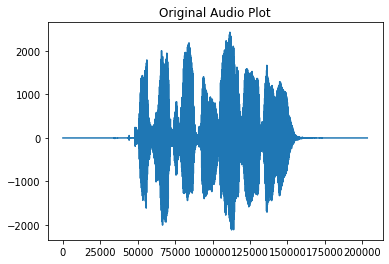

In [3]:
path='/content/drive/MyDrive/data_set/RAVDESS_song/Actor_01/03-02-01-01-01-01-01.wav'
fs, data = wavfile.read(path)
plt.plot(data)            # fs = sampling frequency = 44.1kHz
plt.title("Original Audio Plot")

In [4]:
# Original Sound
samples, sample_rate = librosa.load(path)
ipd.Audio(samples, rate=sample_rate)

In [5]:
with open(path, 'rb') as fd:
    contents = fd.read()

In [6]:
#create random aes symmetric key
AES_key = get_random_bytes(16)   #16 bit = 128 bit encryption

In [7]:
with open('/content/drive/MyDrive/keys/pubkey.pem','rb') as f:
  pubkey = f.read()

In [8]:

RSA_key = RSA.importKey(pubkey)
RSA_cipher = PKCS1_OAEP.new(RSA_key)
e_AESkey=RSA_cipher.encrypt(AES_key)

In [9]:
data=contents

In [10]:
AEScipher=AES.new(AES_key,AES.MODE_EAX)

In [11]:
e_data,tag = AEScipher.encrypt_and_digest(data)

In [12]:
with open('encrypted_audio_RSA_AES.wav', 'wb') as fd:
    fd.write(e_data)
    

In [13]:
samples, sample_rate = librosa.load('encrypted_audio_RSA_AES.wav')
ipd.Audio(samples, rate=sample_rate)

#can't access

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


NoBackendError: ignored

In [14]:
#write both encrypted AES key and encrypted file to one bundled file 
with open('bundle.enc','wb') as f:
  f.write(e_AESkey) #256 bytes
  f.write(AEScipher.nonce) #16 bytes
  f.write(tag) #16 bytes
  f.write(e_data)


# Decryption 

In [15]:
with open('bundle.enc','rb') as f:
  e_AESkey=f.read(128)
  nonce = f.read(16)
  tag = f.read(16)
  e_data = f.read()

In [16]:
with open('/content/drive/MyDrive/keys/privkey.pem') as f:
  key=f.read()


In [17]:
len(e_AESkey)

128

In [18]:
len(key)

891

In [19]:
privkey=RSA.importKey(key)
RSA_cipher=PKCS1_OAEP.new(privkey)
AES_key=RSA_cipher.decrypt(e_AESkey)

In [20]:
try:
  AEScipher=AES.new(AES_key,AES.MODE_EAX,nonce)
  data = AEScipher.decrypt_and_verify(e_data,tag)
except:
  print("Decryption or Authenticity failure")

In [21]:
with open('decrypted_audio_file.wav', 'wb') as fd:
    fd.write(data)
print("A file titled 'encrypted_audio_file.wav' is generated which is the encrypted audio to be communicated")


A file titled 'encrypted_audio_file.wav' is generated which is the encrypted audio to be communicated


In [22]:
samples, sample_rate = librosa.load('decrypted_audio_file.wav')
ipd.Audio(samples, rate=sample_rate)